In [1]:
%cd ../

/home/hoanghu/projects/Food-Waste-Optimization


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from darts.metrics import mse, mae, rmse
from darts.models import ARIMA
from darts.models import ExponentialSmoothing
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode
from tqdm.notebook import tqdm

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/home/hoanghu/miniforge3/envs/fw/lib/python3.9/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# Read dataset

In [5]:
path_processed = "experiments_hoangle/processed/tuntidata_processed.csv"

df = pd.read_csv(path_processed, header=0)

df.head(10)

,datetime,600 Chemicum,610 Physicum,620 Exactum
0,2023-01-02 08:00:00,1.000000,21.093863,1.272727
1,2023-01-02 09:00:00,2.696246,30.945848,1.430769
2,2023-01-02 10:00:00,18.000000,39.682310,2.024390
3,2023-01-02 11:00:00,83.000000,60.064982,138.035398
4,2023-01-02 12:00:00,79.000000,67.358423,121.495575
5,2023-01-02 13:00:00,90.000000,66.043321,66.105727
6,2023-01-02 14:00:00,1.000000,73.896552,4.708333
7,2023-01-02 15:00:00,5.160656,69.133333,NaN
8,2023-01-02 16:00:00,2.935484,32.196203,1.000000
9,2023-01-03 08:00:00,1.000000,21.093863,1.272727


# Forecast

In [6]:
freq = pd.offsets.CustomBusinessHour(start="8:00", end="17:00", weekmask="Mon Tue Wed Thu Fri")
RESTAURANTS = ['600 Chemicum', '610 Physicum', '620 Exactum']

In [18]:
def get_metrics(gt, pred):
    print(f"MSE : {mse(gt, pred):.5f}")
    print(f"RMSE: {rmse(gt, pred):.5f}")
    print(f"MAE : {mae(gt, pred):.5f}")

In [8]:
path_root_trained_model = Path("trained_models")

## A. Univariate

In [39]:

model_name = "ARIMA"

for restaurant in tqdm(RESTAURANTS):
    # Extract time series
    series = TimeSeries.from_dataframe(
        df=df,
        time_col='datetime',
        freq=freq,
        fill_missing_dates = False,
        value_cols=restaurant
    )

    # Define model
    add_encoders = {
        'cyclic': {
            'future': ['hour', 'dayofweek']
        },
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
    }
    model = ARIMA(add_encoders=add_encoders)

    # Train model
    model.fit(series)

    # save model
    tag = restaurant

    path_arima = path_root_trained_model / model_name / f"{tag}.pt"
    path_arima.parent.mkdir(exist_ok=True, parents=True)

    model.save(path_arima)

  0%|          | 0/3 [00:00<?, ?it/s]

/home/hoanghu/miniforge3/envs/foodwaste/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hoanghu/miniforge3/envs/foodwaste/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hoanghu/miniforge3/envs/foodwaste/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# cutoff_date = pd.to_datetime('2024-02-01')
# train_set, test_set = series.split_before(cutoff_date)
# model.fit(train_set)
# pred = model.predict(len(test_set))

# get_metrics(test_set, pred)

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111)

# train_set.plot(ax=ax, label='train')
# test_set.plot(ax=ax, label='test_gt')
# pred.plot(ax=ax, label='test_pred')

## B. Multivariate

<Axes: xlabel='datetime'>

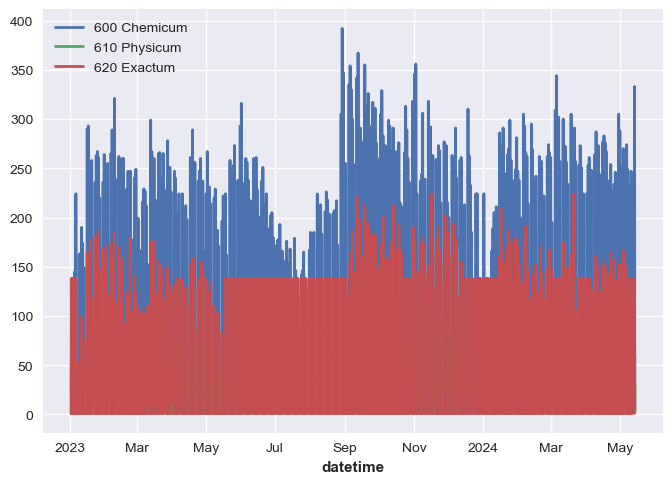

In [7]:
series = TimeSeries.from_dataframe(
    df=df,
    time_col='datetime',
    freq=freq,
    fill_missing_dates = False,
    value_cols=RESTAURANTS
)

series.plot()

In [8]:
cutoff_date = pd.to_datetime('2024-02-01')
train_set, test_set = series.split_before(cutoff_date)

<Axes: xlabel='datetime'>

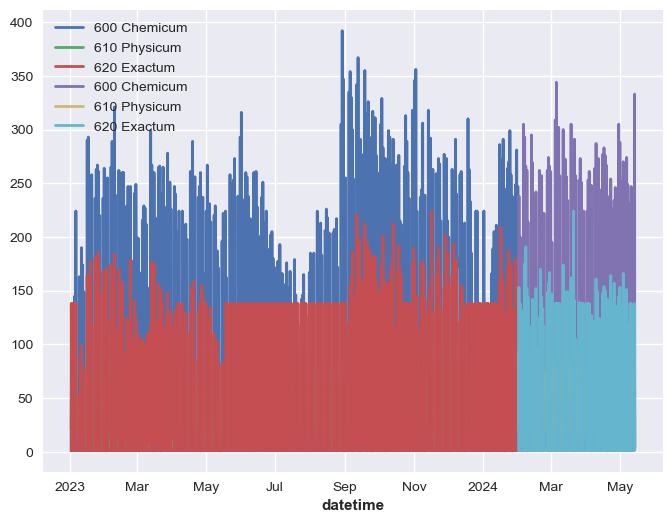

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax)
test_set.plot(ax=ax)

### Exponential Smoothing

In [11]:
model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)

model.fit(train_set)
pred = model.predict(len(test_set))

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

ValueError: Model `ExponentialSmoothing` only supports univariate TimeSeries instances


ValueError: Model `ExponentialSmoothing` only supports univariate TimeSeries instances

### ARIMA with encoders

In [12]:
add_encoders = {
    'cyclic': {
        'past': ['hour', 'dayofweek'],
        'future': ['hour', 'dayofweek']
    },
    # 'datetime_attribute': {'future': ['hour', 'dayofweek']},
}


model = ARIMA(add_encoders=add_encoders)
model.fit(train_set)
pred = model.predict(len(test_set))

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.


ValueError: Model `ARIMA` only supports univariate TimeSeries instances


ValueError: Model `ARIMA` only supports univariate TimeSeries instances

### Bare ARIMA

MSE : 5132.14459
RMSE: 71.63899
MAE : 58.70525


<Axes: xlabel='datetime'>

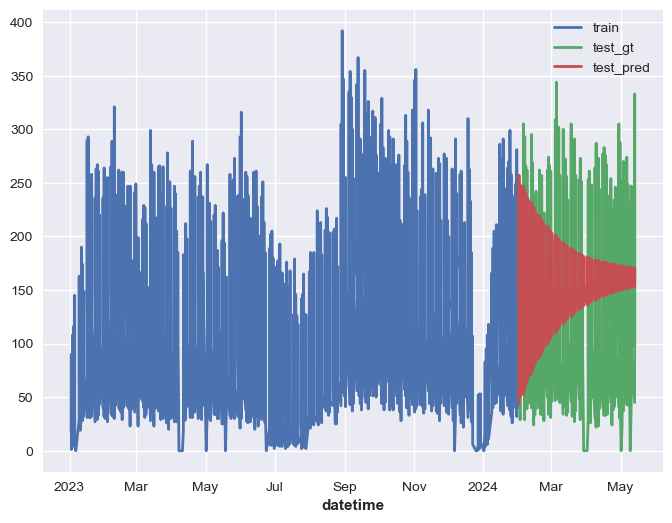

In [13]:
add_encoders = {
    # 'cyclic': {'future': ['hour']},
    # 'datetime_attribute': {'future': ['hour', 'dayofweek']},
}


model = ARIMA(add_encoders=add_encoders)
model.fit(train_set)
pred = model.predict(len(test_set))

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

In [14]:
model.backtest(test_set)

/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

KeyboardInterrupt: 

### Linear Regression

In [ ]:
add_encoders = {
    'cyclic': {
        'past': ['hour', 'dayofweek'],
        'future': ['hour', 'dayofweek']
    },
    # 'datetime_attribute': {'future': ['hour', 'dayofweek']},
}


model = ARIMA(add_encoders=add_encoders)
model.fit(train_set)
pred = model.predict(len(test_set))

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

# Predict

In [10]:
models = {}

model_name = "ARIMA"
add_encoders = {
    'cyclic': {
        'future': ['hour', 'dayofweek']
    },
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
}

for restaurant in tqdm(RESTAURANTS):
    path_arima = path_root_trained_model / model_name / f"{restaurant}.pt"
    models[restaurant] = ARIMA(add_encoders=add_encoders).load(path_arima)

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
days = 1
timestep_per_day = 9

predictions = None

for restaurant in tqdm(RESTAURANTS):
    pred = models[restaurant].predict(days * timestep_per_day)

    if predictions is None:
        predictions = pd.DataFrame({
            'datetime': pred.time_index
        })

    predictions.loc[:, restaurant] = pred.values()

  0%|          | 0/3 [00:00<?, ?it/s]

### post-process

In [31]:
predictions['datetime'] = predictions['datetime'].dt.strftime(r"%Y-%m-%d %H:%M:%S")

predictions.head()

,datetime,600 Chemicum,610 Physicum,620 Exactum
0,2024-05-14 08:00:00,2.350478,7.873081,-3.807754
1,2024-05-14 09:00:00,0.422318,16.790884,-4.829608
2,2024-05-14 10:00:00,46.575678,25.799432,1.869856
3,2024-05-14 11:00:00,267.596160,42.513380,128.556807
4,2024-05-14 12:00:00,317.744216,50.848761,117.478600


0    2024-05-14 08:00:00
1    2024-05-14 09:00:00
2    2024-05-14 10:00:00
3    2024-05-14 11:00:00
4    2024-05-14 12:00:00
5    2024-05-14 13:00:00
6    2024-05-14 14:00:00
7    2024-05-14 15:00:00
8    2024-05-14 16:00:00
Name: datetime, dtype: object

In [32]:
predictions.to_dict('records')

[{'datetime': '2024-05-14 08:00:00',
  '600 Chemicum': 2.3504778928762917,
  '610 Physicum': 7.873081340058377,
  '620 Exactum': -3.807753916169986},
 {'datetime': '2024-05-14 09:00:00',
  '600 Chemicum': 0.42231769331290536,
  '610 Physicum': 16.790884421568023,
  '620 Exactum': -4.829608204622559},
 {'datetime': '2024-05-14 10:00:00',
  '600 Chemicum': 46.57567751539686,
  '610 Physicum': 25.799432100204854,
  '620 Exactum': 1.8698558715301488},
 {'datetime': '2024-05-14 11:00:00',
  '600 Chemicum': 267.5961603645516,
  '610 Physicum': 42.513380143008476,
  '620 Exactum': 128.5568072526379},
 {'datetime': '2024-05-14 12:00:00',
  '600 Chemicum': 317.7442158385561,
  '610 Physicum': 50.8487611867659,
  '620 Exactum': 117.47859994050384},
 {'datetime': '2024-05-14 13:00:00',
  '600 Chemicum': 137.45625916773042,
  '610 Physicum': 56.70820605740499,
  '620 Exactum': 62.86968014247918},
 {'datetime': '2024-05-14 14:00:00',
  '600 Chemicum': 91.95844142383157,
  '610 Physicum': 55.4234389

In [22]:
predictions.to_records(index=False)

rec.array([('2024-05-14T08:00:00.000000000',   2.35047789,  7.87308134,  -3.80775392),
           ('2024-05-14T09:00:00.000000000',   0.42231769, 16.79088442,  -4.8296082 ),
           ('2024-05-14T10:00:00.000000000',  46.57567752, 25.7994321 ,   1.86985587),
           ('2024-05-14T11:00:00.000000000', 267.59616036, 42.51338014, 128.55680725),
           ('2024-05-14T12:00:00.000000000', 317.74421584, 50.84876119, 117.47859994),
           ('2024-05-14T13:00:00.000000000', 137.45625917, 56.70820606,  62.86968014),
           ('2024-05-14T14:00:00.000000000',  91.95844142, 55.42343894,  -0.56865262),
           ('2024-05-14T15:00:00.000000000',  16.30016261, 29.28907317,   5.99798242),
           ('2024-05-14T16:00:00.000000000',   4.05853542, 20.87119741,  -2.52263771)],
          dtype=[('datetime', '<M8[ns]'), ('600 Chemicum', '<f8'), ('610 Physicum', '<f8'), ('620 Exactum', '<f8')])